# EDA


- The os module has a perfect method to list files in a directory.
- Pandas json normalize could work here but is not necessary to convert the JSON data to a dataframe.
- You may need a nested for-loop to access each sale!
- We've put a lot of time into creating the structure of this repository, and it's a good example for future projects.  In the file functions_variables.py, there is an example function that you can import and use.  If you have any variables, functions or classes that you want to make, they can be put in the functions_variables.py file and imported into a notebook.  Note that only .py files can be imported into a notebook. If you want to import everything from a .py file, you can use the following:
```python
from functions_variables import *
```
If you just import functions_variables, then each object from the file will need to be prepended with "functions_variables"\
Using this .py file will keep your notebooks very organized and make it easier to reuse code between notebooks.

## Import basic libraries

In [1]:
# (this is not an exhaustive list of libraries)
import pandas as pd
import numpy as np
import os
import json
from pprint import pprint
from functions_variables import encode_tags

## Data Importing

In [41]:


def flatten_json(json_data, key_prefix="", sep="."):
    """
    Flattens a nested JSON-like dictionary, except for the 'tags' field.
    Args:
        json_data: The JSON data (dictionary) to flatten.
        key_prefix:  A prefix to add to the keys (used for recursion).
        sep: The separator to use between nested keys.
    Returns:
        A flattened dictionary.
    """
    flattened = {}
    for k, v in json_data.items():
        new_key = key_prefix + k if key_prefix else k
        if k == "tags":
            flattened[new_key] = v
        elif isinstance(v, dict):
            flattened.update(flatten_json(v, new_key + sep, sep=sep))
        elif isinstance(v, list):
            for i, item in enumerate(v):
                if isinstance(item, dict):
                    flattened.update(flatten_json(item, new_key + f"[{i}]" + sep, sep=sep))
                else:
                    flattened[new_key + f"[{i}]"] = item
        elif v is None:
            flattened[new_key] = None
        else:
            flattened[new_key] = v
    return flattened

def extract_data_from_json_files(directory):
    """
    Extracts data from JSON files in the specified directory and combines them into a single DataFrame.
    
    Args:
        directory: The directory containing the JSON files.
        
    Returns:
        A Pandas DataFrame containing the combined data from all JSON files.
    """
    all_data = []
    
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            file_path = os.path.join(directory, filename)
            try:
                with open(file_path, "r") as f:
                    data = json.load(f)
                # Extract the 'results' list from the JSON data
                results = data.get("data", {}).get("results", [])
                # Flatten each result and store in a list
                flattened_data = [flatten_json(result) for result in results]
                all_data.extend(flattened_data)
            except (FileNotFoundError, json.JSONDecodeError) as e:
                print(f"Error processing file {file_path}: {e}")
    
    # Create the Pandas DataFrame
    combined_df = pd.DataFrame(all_data)
    
    return combined_df

# Directory containing the JSON files
directory = "/Users/fitsumbahlebi/Desktop/repo2/LHL-supervised-learning-midterm/data"

# Extract data and create the combined DataFrame
combined_df = extract_data_from_json_files(directory)

# Display the combined DataFrame
print(combined_df.head())

                                  primary_photo.href      last_update_date  \
0  https://ap.rdcpix.com/8c0b391ae4f9bbca36c41d55...  2024-01-17T00:01:55Z   
1  https://ap.rdcpix.com/40c55dc5d4e29ab361ae973e...  2024-01-16T16:49:36Z   
2  https://ap.rdcpix.com/497a833c1c423b26b4f0e5bc...  2024-01-13T00:03:39Z   
3  https://ap.rdcpix.com/ade15664a2e83986c126a23d...  2024-01-16T07:48:30Z   
4  https://ap.rdcpix.com/a5dada323a7e617f2dcc4850...  2024-01-13T00:01:45Z   

  source.plan_id source.agents[0].office_name source.agents[1].office_name  \
0           None                         None                         None   
1           None                         None                         None   
2           None                         None                         None   
3           None                         None                         None   
4           None                         None                         None   

  source.spec_id source.type  \
0           None         mls  

## Data Cleaning and Wrangling

At this point, ensure that you have all sales in a dataframe.
- Take a quick look at your data (i.e. `.info()`, `.describe()`) - what do you see?
- Is each cell one value, or do some cells have lists?
- What are the data types of each column?
- Some sales may not actually include the sale price (target).  These rows should be dropped.
- There are a lot of NA/None values.  Should these be dropped or replaced with something?
    - You can drop rows or use various methods to fills NA's - use your best judgement for each column 
    - i.e. for some columns (like Garage), NA probably just means no Garage, so 0
- Drop columns that aren't needed
    - Don't keep the list price because it will be too close to the sale price. Assume we want to predict the price of houses not yet listed

### Drop irrelevant columns

In [81]:
columns_to_drop = [
    # Photo-related columns
    'primary_photo.href', 'photos[0].tags', 'photos[0].href',
    'photos[1].tags', 'photos[1].href', 'photos[2].tags', 
    'photos[2].href', 'photos[3].tags', 'photos[3].href',
    'photos[4].tags', 'photos[4].href', 'primary_photo', 'photos',

    # Office and agent related columns
    'source.agents[0].office_name', 'source.agents[1].office_name',
    'source.agents[2].office_name', 'source.agents[3].office_name',
    'community.advertisers[0].office.hours',
    'community.advertisers[0].office.phones[0].number',
    'community.advertisers[0].office.phones[0].type',
    'community.description.name',
    
    # Virtual tour related columns
    'virtual_tours[0].href', 'virtual_tours[0].type', 'virtual_tours',
    
    # Other listings related columns
    'other_listings.rdc[0].listing_id', 'other_listings.rdc[0].status', 
    'other_listings.rdc[4].listing_id', 'other_listings.rdc[4].status',
    'other_listings.rdc[5].listing_id', 'other_listings.rdc[5].status',
    'other_listings.rdc[6].listing_id', 'other_listings.rdc[6].status',
    'other_listings.rdc[7].listing_id', 'other_listings.rdc[7].status',
    'other_listings.rdc[8].listing_id', 'other_listings.rdc[8].status',
    'other_listings.rdc[9].listing_id', 'other_listings.rdc[9].status',
    'other_listings.rdc[10].listing_id', 'other_listings.rdc[10].status',
    'other_listings.rdc[11].listing_id', 'other_listings.rdc[11].status',
    'other_listings.rdc[12].listing_id', 'other_listings.rdc[12].status',
    'other_listings.rdc[13].listing_id', 'other_listings.rdc[13].status',
    'other_listings.rdc[14].listing_id', 'other_listings.rdc[14].status',
    'other_listings.rdc[15].listing_id', 'other_listings.rdc[15].status',
    'other_listings', 'other_listings.rdc[0].primary', 'other_listings.rdc[1].primary',
    'other_listings.rdc[1].listing_id', 'other_listings.rdc[1].status', 
    'other_listings.rdc[2].listing_id', 'other_listings.rdc[2].status', 
    'other_listings.rdc[3].listing_id', 'other_listings.rdc[3].status', 
    'other_listings.rdc[3].primary', 'other_listings.rdc[2].primary',
    'other_listings.rdc[2].listing_key', 'status','source.type',
    'other_listings.rdc[3].listing_key', 'branding[0].photo',
    'other_listings.rdc[4].listing_key', 'other_listings.rdc[4].primary',
    'other_listings.rdc[5].listing_key', 'other_listings.rdc[5].primary',
    'other_listings.rdc[6].listing_key', 'other_listings.rdc[6].primary',
    'other_listings.rdc[7].listing_key', 'other_listings.rdc[7].primary',
    'other_listings.rdc[8].listing_key', 'other_listings.rdc[8].primary',
    'other_listings.rdc[9].listing_key', 'other_listings.rdc[9].primary',
    'other_listings.rdc[10].listing_key', 'other_listings.rdc[10].primary',
    'other_listings.rdc[11].listing_key', 'other_listings.rdc[11].primary',
    'other_listings.rdc[12].listing_key', 'other_listings.rdc[12].primary',
    'other_listings.rdc[13].listing_key', 'other_listings.rdc[13].primary',
    'other_listings.rdc[14].listing_key', 'other_listings.rdc[14].primary',
    'other_listings.rdc[15].listing_key', 'other_listings.rdc[15].primary',
    'other_listings.rdc[0].listing_key', 'other_listings.rdc[1].listing_key',

    # Source and metadata related columns
    'source.plan_id', 'source.spec_id', 'source', 'products',
    'last_update_date', 'lead_attributes.show_contact_an_agent',
    'location.county.fips_code', 'location.address.coordinate',
    'flags.is_foreclosure','permalink',
    
    # Empty Columns
    'baths_1qtr', 'location.county', 'property_name', 'is_subdivision',
    'is_for_rent', 'is_new_construction', 'is_pending', 'is_plan',
    'is_coming_soon', 'community', 'baths_1qtr', 'is_contingent',
    'open_houses', 'description.name', 'branding[0].name', 'description.baths_1qtr',
    'branding[0].type', 'flags.is_new_construction', 'flags.is_for_rent',
    'flags.is_subdivision', 'flags.is_contingent', 'flags.is_pending', 'flags.is_plan',
    'flags.is_coming_soon', 'listing_id', 'location.street_view_url'
]
# Drop the specified columns from the DataFrame
combined_after_drop_df = combined_df.drop(columns=columns_to_drop, axis=1,errors='ignore')

### Checking for unique Values

In [82]:
# Check unique values for each column in non_zero_cols

for col in combined_after_drop_df.columns:
    print(f"\nColumn: {col}")
    try:
        # Handle list-type columns differently
        if col == 'property_tags':
            # Get all unique tags across all lists
            all_tags = set()
            for tags in combined_df[col].dropna():
                if isinstance(tags, list):
                    all_tags.update(tags)
            print("Unique tags found:", len(all_tags))
            print("Sample of tags:", list(all_tags)[:5])
        else:
            unique_values = combined_df[col].unique()
            print(f"Count of unique values: {len(unique_values)}")
            print("Sample values:", unique_values[:5])
    except Exception as e:
        print(f"Could not process column due to: {str(e)}")
        
    if col != 'property_tags':  # Skip checking tags
        try:
            unique_values = combined_df[col].unique()
            print(f"Count of unique values: {len(unique_values)}")
            print("Sample values:", unique_values[:5])
        except Exception as e:
            print(f"Could not process column due to: {str(e)}")
    print("-" * 50)


Column: tags
Could not process column due to: unhashable type: 'list'
Could not process column due to: unhashable type: 'list'
--------------------------------------------------

Column: list_date
Count of unique values: 1637
Sample values: ['2023-11-27T05:15:07.000000Z' '2023-11-23T11:38:45.000000Z'
 '2023-12-16T02:39:18.000000Z' '2023-10-24T14:15:02.000000Z'
 '2023-11-15T17:43:35.000000Z']
Count of unique values: 1637
Sample values: ['2023-11-27T05:15:07.000000Z' '2023-11-23T11:38:45.000000Z'
 '2023-12-16T02:39:18.000000Z' '2023-10-24T14:15:02.000000Z'
 '2023-11-15T17:43:35.000000Z']
--------------------------------------------------

Column: description.year_built
Count of unique values: 148
Sample values: [2001. 1900. 1971. 2013. 1940.]
Count of unique values: 148
Sample values: [2001. 1900. 1971. 2013. 1940.]
--------------------------------------------------

Column: description.baths_3qtr
Count of unique values: 4
Sample values: [nan  1.  3.  2.]
Count of unique values: 4
Sampl

In [83]:
display(combined_after_drop_df.shape)
display("====================================")
# Display the updated DataFrame
display(combined_after_drop_df.head())
display("====================================")
display(combined_after_drop_df.columns)
display("====================================")
display (combined_after_drop_df.info())

(8159, 31)

'===================================='

,tags,list_date,description.year_built,description.baths_3qtr,description.sold_date,description.sold_price,description.baths_full,description.baths_half,description.lot_sqft,description.sqft,...,price_reduced_amount,location.address.postal_code,location.address.state,location.address.coordinate.lon,location.address.coordinate.lat,location.address.city,location.address.state_code,location.address.line,location.county.name,matterport
0,"[central_air, dishwasher, fireplace, forced_ai...",2023-11-27T05:15:07.000000Z,2001.0,NaN,2024-01-16,345000.0,2.0,NaN,22651.0,1539.0,...,NaN,17110,Pennsylvania,-76.865096,40.316612,Harrisburg,PA,1869 Pebble Ct,Dauphin,False
1,"[disability_features, basement, garage_1_or_mo...",2023-11-23T11:38:45.000000Z,1900.0,NaN,2024-01-16,196000.0,NaN,NaN,2614.0,2429.0,...,NaN,17110,Pennsylvania,-76.900123,40.296987,Harrisburg,PA,3100 N 3rd St,Dauphin,False
2,"[carport, central_air, dishwasher, fireplace, ...",2023-12-16T02:39:18.000000Z,1971.0,NaN,2024-01-12,205000.0,2.0,NaN,13504.0,1120.0,...,NaN,17111,Pennsylvania,-76.757031,40.257449,Harrisburg,PA,7551 Davids Rd,Dauphin,False
3,"[central_air, dining_room, disability_features...",2023-10-24T14:15:02.000000Z,2013.0,NaN,2024-01-12,295000.0,2.0,1.0,2688.0,2400.0,...,NaN,17112,Pennsylvania,-76.821034,40.350224,Harrisburg,PA,2722 Bur Ct,Dauphin,False
4,"[dining_room, hardwood_floors, basement]",2023-11-15T17:43:35.000000Z,1900.0,NaN,2024-01-12,106000.0,NaN,NaN,871.0,1478.0,...,NaN,17104,Pennsylvania,-76.869911,40.259374,Harrisburg,PA,404 Crescent St,Dauphin,False


'===================================='

Index(['tags', 'list_date', 'description.year_built', 'description.baths_3qtr',
       'description.sold_date', 'description.sold_price',
       'description.baths_full', 'description.baths_half',
       'description.lot_sqft', 'description.sqft', 'description.baths',
       'description.sub_type', 'description.garage', 'description.stories',
       'description.beds', 'description.type', 'list_price', 'property_id',
       'flags.is_price_reduced', 'flags.is_new_listing', 'products.brand_name',
       'price_reduced_amount', 'location.address.postal_code',
       'location.address.state', 'location.address.coordinate.lon',
       'location.address.coordinate.lat', 'location.address.city',
       'location.address.state_code', 'location.address.line',
       'location.county.name', 'matterport'],
      dtype='object')

'===================================='

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8159 entries, 0 to 8158
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   tags                             7638 non-null   object 
 1   list_date                        7752 non-null   object 
 2   description.year_built           7316 non-null   float64
 3   description.baths_3qtr           566 non-null    float64
 4   description.sold_date            8159 non-null   object 
 5   description.sold_price           6716 non-null   float64
 6   description.baths_full           7311 non-null   float64
 7   description.baths_half           2281 non-null   float64
 8   description.lot_sqft             6991 non-null   float64
 9   description.sqft                 7323 non-null   float64
 10  description.baths                7980 non-null   float64
 11  description.sub_type             1427 non-null   object 
 12  description.garage  

None

In [84]:
# Get columns with less than 500 nulls and their null counts
null_counts = combined_after_drop_df.isnull().sum()
columns_with_less_than_500_nulls = null_counts[null_counts > 500]
display(columns_with_less_than_500_nulls.sort_values(ascending=False))




description.baths_3qtr    7593
description.sub_type      6732
description.baths_half    5878
flags.is_price_reduced    5675
price_reduced_amount      5675
description.garage        3711
description.stories       1899
description.sold_price    1443
description.lot_sqft      1168
description.baths_full     848
description.year_built     843
description.sqft           836
description.beds           655
tags                       521
dtype: int64

### Renaming the Columns

In [85]:

new_column_names = {
    'source.type': 'listing_source',
    'tags': 'property_tags',
    'permalink': 'full_address',
    'status': 'listing_status',
    'list_date': 'list_date',
    'description.year_built': 'year_built',
    'description.baths_3qtr': 'baths_3qtr',
    'description.sold_date': 'sold_date',
    'description.sold_price': 'sold_price',
    'description.baths_full': 'baths_full',
    'description.name' : 'property_name',
    'description.baths_half': 'baths_half',
    'description.lot_sqft': 'lot_sqft',
    'description.sqft': 'sqft',
    'description.baths': 'baths_total',
    'description.sub_type': 'property_subtype',
    'description.baths_1qtr': 'baths_1qtr',
    'description.garage': 'garage_spaces',
    'description.stories': 'num_stories',
    'description.beds': 'beds',
    'description.type': 'property_type',
    'branding[0].name': 'listing_company_name',
    'branding[0].type': 'listing_company_type',
    'list_price': 'list_price',
    'property_id': 'property_id',
    'flags.is_new_construction' : 'is_new_construction',
    'flags.is_for_rent' : 'is_for_rent', 
    'flags.is_subdivision': 'is_subdivision',
    'flags.is_contingent': 'is_contingent', 
    'flags.is_pending' : 'is_pending', 
    'flags.is_plan' : 'is_plan',
    'flags.is_coming_soon' : 'is_coming_soon',
    'flags.is_price_reduced': 'is_price_reduced',
    'flags.is_new_listing': 'is_new_listing',
    'products.brand_name': 'product_brand',
    'listing_id': 'listing_id',
    'price_reduced_amount': 'price_reduction',
    'location.address.postal_code': 'postal_code',
    'location.address.state': 'state',
    'location.address.coordinate.lon': 'longitude',
    'location.address.coordinate.lat': 'latitude',
    'location.address.city': 'city',
    'location.address.state_code': 'state_code',
    'location.address.line': 'address',
    'location.street_view_url': 'street_view_url',
    'location.county.name': 'county',
    'matterport': 'has_matterport'
}

combined_df_renamed= combined_after_drop_df.rename(columns=new_column_names)

print(combined_df_renamed.columns)  # Verify the column names have changed
print("====================================")
combined_df_renamed.head()  # Display the first few rows of the DataFrame

Index(['property_tags', 'list_date', 'year_built', 'baths_3qtr', 'sold_date',
       'sold_price', 'baths_full', 'baths_half', 'lot_sqft', 'sqft',
       'baths_total', 'property_subtype', 'garage_spaces', 'num_stories',
       'beds', 'property_type', 'list_price', 'property_id',
       'is_price_reduced', 'is_new_listing', 'product_brand',
       'price_reduction', 'postal_code', 'state', 'longitude', 'latitude',
       'city', 'state_code', 'address', 'county', 'has_matterport'],
      dtype='object')


,property_tags,list_date,year_built,baths_3qtr,sold_date,sold_price,baths_full,baths_half,lot_sqft,sqft,...,price_reduction,postal_code,state,longitude,latitude,city,state_code,address,county,has_matterport
0,"[central_air, dishwasher, fireplace, forced_ai...",2023-11-27T05:15:07.000000Z,2001.0,NaN,2024-01-16,345000.0,2.0,NaN,22651.0,1539.0,...,NaN,17110,Pennsylvania,-76.865096,40.316612,Harrisburg,PA,1869 Pebble Ct,Dauphin,False
1,"[disability_features, basement, garage_1_or_mo...",2023-11-23T11:38:45.000000Z,1900.0,NaN,2024-01-16,196000.0,NaN,NaN,2614.0,2429.0,...,NaN,17110,Pennsylvania,-76.900123,40.296987,Harrisburg,PA,3100 N 3rd St,Dauphin,False
2,"[carport, central_air, dishwasher, fireplace, ...",2023-12-16T02:39:18.000000Z,1971.0,NaN,2024-01-12,205000.0,2.0,NaN,13504.0,1120.0,...,NaN,17111,Pennsylvania,-76.757031,40.257449,Harrisburg,PA,7551 Davids Rd,Dauphin,False
3,"[central_air, dining_room, disability_features...",2023-10-24T14:15:02.000000Z,2013.0,NaN,2024-01-12,295000.0,2.0,1.0,2688.0,2400.0,...,NaN,17112,Pennsylvania,-76.821034,40.350224,Harrisburg,PA,2722 Bur Ct,Dauphin,False
4,"[dining_room, hardwood_floors, basement]",2023-11-15T17:43:35.000000Z,1900.0,NaN,2024-01-12,106000.0,NaN,NaN,871.0,1478.0,...,NaN,17104,Pennsylvania,-76.869911,40.259374,Harrisburg,PA,404 Crescent St,Dauphin,False


### Data type conversion

In [86]:
from pandas import Int64Dtype

# Convert to boolean
def booleanConverter(column):
    combined_df_renamed[column] = combined_df_renamed[column].map({'True':True, 'False':False})
    return column
# Convert to datetime
combined_df_renamed['list_date'] = pd.to_datetime(combined_df_renamed['list_date'], errors='coerce', utc = True)  # 'coerce' will turn invalid dates into NaT
combined_df_renamed['sold_date'] = pd.to_datetime(combined_df_renamed['sold_date'], errors='coerce', utc = True)

# Integer columns (using Int64 to handle missing values)
numerical_features = ['year_built', 'baths_3qtr', 'baths_full', 'baths_half','baths_total' , 'sold_price', 'price_reduction','garage_spaces', 'num_stories', 'beds']
for col in numerical_features:
    combined_df_renamed[col] = combined_df_renamed[col].astype(Int64Dtype())

#Boolean Converter function
bool_like = ['is_price_reduced', 'is_new_listing', 'has_matterport']
for column in bool_like:
    combined_df_renamed[column] = np.where(combined_df_renamed[column].isin(['True', 'False']), combined_df_renamed[column].map({'True': True, 'False': False}), combined_df_renamed[column])
    combined_df_renamed[column] = combined_df_renamed[column].fillna(False).astype(int) # Convert to 0 and 1
# Convert to category
category_cols = ['property_subtype', 'property_type', 'city', 'state', 'state_code', 'county']
for col in category_cols:
    combined_df_renamed[col] = combined_df_renamed[col].astype('category')
# Print dtypes to verify
print(combined_df_renamed.dtypes)
print("====================================")
display(combined_df_renamed.head())

property_tags                    object
list_date           datetime64[ns, UTC]
year_built                        Int64
baths_3qtr                        Int64
sold_date           datetime64[ns, UTC]
sold_price                        Int64
baths_full                        Int64
baths_half                        Int64
lot_sqft                        float64
sqft                            float64
baths_total                       Int64
property_subtype               category
garage_spaces                     Int64
num_stories                       Int64
beds                              Int64
property_type                  category
list_price                      float64
property_id                      object
is_price_reduced                  int64
is_new_listing                    int64
product_brand                    object
price_reduction                   Int64
postal_code                      object
state                          category
longitude                       float64


,property_tags,list_date,year_built,baths_3qtr,sold_date,sold_price,baths_full,baths_half,lot_sqft,sqft,...,price_reduction,postal_code,state,longitude,latitude,city,state_code,address,county,has_matterport
0,"[central_air, dishwasher, fireplace, forced_ai...",2023-11-27 05:15:07+00:00,2001,<NA>,2024-01-16 00:00:00+00:00,345000,2,<NA>,22651.0,1539.0,...,<NA>,17110,Pennsylvania,-76.865096,40.316612,Harrisburg,PA,1869 Pebble Ct,Dauphin,0
1,"[disability_features, basement, garage_1_or_mo...",2023-11-23 11:38:45+00:00,1900,<NA>,2024-01-16 00:00:00+00:00,196000,<NA>,<NA>,2614.0,2429.0,...,<NA>,17110,Pennsylvania,-76.900123,40.296987,Harrisburg,PA,3100 N 3rd St,Dauphin,0
2,"[carport, central_air, dishwasher, fireplace, ...",2023-12-16 02:39:18+00:00,1971,<NA>,2024-01-12 00:00:00+00:00,205000,2,<NA>,13504.0,1120.0,...,<NA>,17111,Pennsylvania,-76.757031,40.257449,Harrisburg,PA,7551 Davids Rd,Dauphin,0
3,"[central_air, dining_room, disability_features...",2023-10-24 14:15:02+00:00,2013,<NA>,2024-01-12 00:00:00+00:00,295000,2,1,2688.0,2400.0,...,<NA>,17112,Pennsylvania,-76.821034,40.350224,Harrisburg,PA,2722 Bur Ct,Dauphin,0
4,"[dining_room, hardwood_floors, basement]",2023-11-15 17:43:35+00:00,1900,<NA>,2024-01-12 00:00:00+00:00,106000,<NA>,<NA>,871.0,1478.0,...,<NA>,17104,Pennsylvania,-76.869911,40.259374,Harrisburg,PA,404 Crescent St,Dauphin,0


In [88]:
combined_df_renamed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8159 entries, 0 to 8158
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   property_tags     7638 non-null   object             
 1   list_date         7401 non-null   datetime64[ns, UTC]
 2   year_built        7316 non-null   Int64              
 3   baths_3qtr        566 non-null    Int64              
 4   sold_date         8159 non-null   datetime64[ns, UTC]
 5   sold_price        6716 non-null   Int64              
 6   baths_full        7311 non-null   Int64              
 7   baths_half        2281 non-null   Int64              
 8   lot_sqft          6991 non-null   float64            
 9   sqft              7323 non-null   float64            
 10  baths_total       7980 non-null   Int64              
 11  property_subtype  1427 non-null   category           
 12  garage_spaces     4448 non-null   Int64              
 13  num

In [89]:
combined_df_renamed.describe()

,year_built,baths_3qtr,sold_price,baths_full,baths_half,lot_sqft,sqft,baths_total,garage_spaces,num_stories,beds,list_price,is_price_reduced,is_new_listing,price_reduction,longitude,latitude,has_matterport
count,7316.0,566.0,6716.0,7311.0,2281.0,6.991000e+03,7323.000000,7980.0,4448.0,6260.0,7504.0,7.721000e+03,8159.000000,8159.0,2484.0,7909.000000,7909.000000,8159.000000
mean,1968.916074,1.24735,412605.030375,1.88743,1.105655,2.510949e+05,1933.848559,2.131203,1.926709,1.567732,3.208289,4.341582e+05,0.009437,0.0,24427.038245,-92.206522,39.009689,0.040324
std,35.096914,0.463482,699430.834314,0.862214,0.41334,5.823820e+06,1339.039206,1.17594,0.878766,0.730969,1.282732,5.514925e+05,0.096693,0.0,71623.956095,15.888886,4.374553,0.196729
min,1828.0,1.0,308.0,1.0,1.0,0.000000e+00,120.000000,0.0,1.0,1.0,0.0,1.000000e+00,0.000000,0.0,100.0,-157.810583,21.277707,0.000000
25%,1950.0,1.0,191000.0,1.0,1.0,4.953000e+03,1258.000000,1.0,1.0,1.0,3.0,2.090000e+05,0.000000,0.0,6000.0,-104.971611,35.688084,0.000000
50%,1975.0,1.0,314000.0,2.0,1.0,7.841000e+03,1635.000000,2.0,2.0,1.0,3.0,3.250000e+05,0.000000,0.0,10100.0,-89.333131,39.698210,0.000000
75%,1997.0,1.0,470000.0,2.0,1.0,1.263200e+04,2264.000000,3.0,2.0,2.0,4.0,4.999000e+05,0.000000,0.0,20000.0,-78.617690,41.832266,0.000000
max,2024.0,3.0,27065000.0,8.0,5.0,1.676624e+08,32106.000000,9.0,11.0,10.0,12.0,1.250000e+07,1.000000,0.0,2015999.0,-71.006343,58.396178,1.000000


In [97]:
# Correct the typo
combined_df_renamed['property_type'] = combined_df_renamed['property_type'].replace('condos', 'condo')

# Ensure categories are identical before filling NaNs
# Convert to string before filling NaNs
if 'property_subtype' in combined_df_renamed.columns:
    combined_df_renamed['property_subtype'] = combined_df_renamed['property_subtype'].astype(str)
    new_categories = combined_df_renamed['property_subtype'].unique()
    existing_categories = combined_df_renamed['property_type'].cat.categories
    categories_to_add = [cat for cat in new_categories if cat not in existing_categories]
    combined_df_renamed['property_type'] = combined_df_renamed['property_type'].cat.add_categories(categories_to_add)
    combined_df_renamed['property_type'].fillna(combined_df_renamed['property_subtype'], inplace=True)
    combined_df_renamed.drop(columns=['property_subtype'], inplace=True)

# Drop 'list_price' inorder to predict the price of houses not yet listed, too close to the sale price
combined_df_renamed = combined_df_renamed.drop(columns=['list_price'], errors='ignore')

# Convert datetime columns before handling other numeric columns
combined_df_renamed['list_date'] = pd.to_datetime(combined_df_renamed['list_date'], errors='coerce')
combined_df_renamed['sold_date'] = pd.to_datetime(combined_df_renamed['sold_date'], errors='coerce')

# Drop rows with missing 'sold_price' values
combined_df_renamed = combined_df_renamed.dropna(subset=['sold_price'])

#Impute longitude and lattitude
combined_df_renamed['latitude'] = combined_df_renamed['latitude'].fillna(combined_df_renamed.groupby('postal_code')['latitude'].transform('median'))
combined_df_renamed['longitude'] = combined_df_renamed['longitude'].fillna(combined_df_renamed.groupby('postal_code')['longitude'].transform('median'))

# Impute year_built with median
combined_df_renamed['year_built'].fillna(combined_df_renamed['year_built'].median(), inplace=True)

# Impute baths_3qtr and baths_half with 0
combined_df_renamed['baths_3qtr'].fillna(0, inplace=True)
combined_df_renamed['baths_half'].fillna(0, inplace=True)
# Impute missing values in 'garage_spaces' with the 0
combined_df_renamed['garage_spaces'].fillna(0, inplace=True)

#Impute with most frequent values.
combined_df_renamed["product_brand"].fillna(combined_df_renamed["product_brand"].mode()[0], inplace = True)
# Impute baths_full and baths_total with median
combined_df_renamed['baths_full'].fillna(combined_df_renamed['baths_full'].median(), inplace=True)
combined_df_renamed['baths_total'].fillna(combined_df_renamed['baths_total'].median(), inplace=True)

# Impute lot_sqft and sqft with median
combined_df_renamed['lot_sqft'].fillna(combined_df_renamed['lot_sqft'].median(), inplace=True)
combined_df_renamed['sqft'].fillna(combined_df_renamed['sqft'].median(), inplace=True)

# Impute garage_spaces with 0
combined_df_renamed['garage_spaces'].fillna(0, inplace=True)

# Impute num_stories with mode
combined_df_renamed['num_stories'].fillna(combined_df_renamed['num_stories'].mode()[0], inplace=True)

# Impute beds with median
combined_df_renamed['beds'].fillna(combined_df_renamed['beds'].median(), inplace=True)

# Impute property_type with mode
combined_df_renamed['property_type'].fillna(combined_df_renamed['property_type'].mode()[0], inplace=True)

# For each postal code impute the date with the median sold_date for properties in that postal code
combined_df_renamed['list_date'] = combined_df_renamed['list_date'].fillna(
    combined_df_renamed.groupby('postal_code')['sold_date'].transform(lambda x: x.median() if not x.empty else pd.NaT)
)

# Fill any remaining NaT values with the overall median
if combined_df_renamed['list_date'].isna().any():
    combined_df_renamed['list_date'] = combined_df_renamed['list_date'].fillna(combined_df_renamed['list_date'].median())

# Impute price_reduction (conditional)
combined_df_renamed['price_reduction'] = np.where(combined_df_renamed['is_price_reduced'], combined_df_renamed['price_reduction'].fillna(combined_df_renamed['price_reduction'].median()), 0)

#Handle the updated list_date, listing_id, address and county
# Impute list_date
# For each postal code impute the date with the median sold_date for properties in that postal code
combined_df_renamed['list_date'] = combined_df_renamed['list_date'].fillna(combined_df_renamed.groupby('postal_code')['sold_date'].transform('median'))

#Impute address
# Use a lambda function to handle cases where there's no mode
combined_df_renamed['address'] = combined_df_renamed['address'].fillna(
    combined_df_renamed.groupby('county')['address'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
)

#Impute County
# Use a lambda function to handle cases where there's no mode
combined_df_renamed['county'] = combined_df_renamed['county'].fillna(
    combined_df_renamed.groupby('postal_code')['county'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
)

#Impute City
# Use a lambda function to handle cases where there's no mode
combined_df_renamed['city'] = combined_df_renamed['city'].fillna(
    combined_df_renamed.groupby('postal_code')['city'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
)
# Attempt to impute remaining latitude/longitude with overall median
combined_df_renamed['latitude'].fillna(combined_df_renamed['latitude'].median(), inplace=True)
combined_df_renamed['longitude'].fillna(combined_df_renamed['longitude'].median(), inplace=True)

print(combined_df_renamed.isnull().sum().sort_values(ascending=False))  # Verify that null values have been handled


age_built           675
property_tags       386
year_built            0
baths_3qtr            0
has_matterport        0
county                0
address               0
state_code            0
city                  0
latitude              0
longitude             0
state                 0
postal_code           0
price_reduction       0
product_brand         0
is_new_listing        0
is_price_reduced      0
list_date             0
property_type         0
beds                  0
num_stories           0
garage_spaces         0
baths_total           0
sqft                  0
lot_sqft              0
baths_half            0
baths_full            0
sold_price            0
sold_date             0
property_id           0
dtype: int64


In [98]:
# Create a new column 'age_built' by subtracting 'year_built' from the current year
now = pd.to_datetime('now')  # get current datetime
combined_df_renamed['age_built'] = (now.year - combined_df_renamed['year_built']).astype('float64')

In [99]:
# Check information
combined_df_renamed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6716 entries, 0 to 8158
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   property_tags     6330 non-null   object             
 1   list_date         6716 non-null   datetime64[ns, UTC]
 2   year_built        6716 non-null   Int64              
 3   baths_3qtr        6716 non-null   Int64              
 4   sold_date         6716 non-null   datetime64[ns, UTC]
 5   sold_price        6716 non-null   Int64              
 6   baths_full        6716 non-null   Int64              
 7   baths_half        6716 non-null   Int64              
 8   lot_sqft          6716 non-null   float64            
 9   sqft              6716 non-null   float64            
 10  baths_total       6716 non-null   Int64              
 11  garage_spaces     6716 non-null   Int64              
 12  num_stories       6716 non-null   Int64              
 13  beds    

In [100]:
# Descriptive statistics
combined_df_renamed.describe()

,year_built,baths_3qtr,sold_price,baths_full,baths_half,lot_sqft,sqft,baths_total,garage_spaces,num_stories,beds,is_price_reduced,is_new_listing,longitude,latitude,has_matterport,age_built
count,6716.0,6716.0,6716.0,6716.0,6716.0,6.716000e+03,6716.000000,6716.0,6716.0,6716.0,6716.0,6716.000000,6716.0,6716.000000,6716.000000,6716.000000,6716.000000
mean,1967.076087,0.070578,412605.030375,1.891751,0.31894,1.306171e+05,1878.690739,2.121352,0.987641,1.45265,3.196546,0.009976,0.0,-89.479154,39.172065,0.035736,57.923913
std,34.123581,0.309335,699430.834314,0.807292,0.532884,3.797076e+06,1278.031485,1.145947,1.15899,0.707785,1.253947,0.099389,0.0,15.518625,3.827715,0.185644,34.123581
min,1828.0,0.0,308.0,1.0,0.0,0.000000e+00,120.000000,0.0,0.0,1.0,0.0,0.000000,0.0,-157.810583,21.277707,0.000000,2.000000
25%,1950.0,0.0,191000.0,1.0,0.0,5.314000e+03,1290.000000,1.0,0.0,1.0,3.0,0.000000,0.0,-96.601016,36.146606,0.000000,32.000000
50%,1972.0,0.0,314000.0,2.0,0.0,7.841000e+03,1629.000000,2.0,1.0,1.0,3.0,0.000000,0.0,-84.794159,39.721094,0.000000,53.000000
75%,1993.0,0.0,470000.0,2.0,1.0,1.132600e+04,2144.000000,3.0,2.0,2.0,4.0,0.000000,0.0,-76.899321,41.800411,0.000000,75.000000
max,2023.0,2.0,27065000.0,7.0,5.0,1.390435e+08,32106.000000,9.0,11.0,10.0,12.0,1.000000,0.0,-71.006343,47.174260,1.000000,197.000000


### Validation: Check for Lists or dicts in the cols

In [101]:
import pandas as pd

def check_columns_with_lists_or_dicts(df):
    """
    Checks whether columns in the DataFrame contain either lists or dictionaries (or both).
    
    Args:
        df: The Pandas DataFrame to check.
        
    Returns:
        A list of column names where either lists or dictionaries (or both) are present.
    """
    columns_with_lists_or_dicts = []
    
    for col in df.columns:
        contains_list = any(isinstance(item, list) for item in df[col])
        contains_dict = any(isinstance(item, dict) for item in df[col])
        if contains_list or contains_dict:
            columns_with_lists_or_dicts.append(col)
    
    return columns_with_lists_or_dicts

# Call the function with the DataFrame
columns_with_lists_or_dicts = check_columns_with_lists_or_dicts(combined_df_renamed)
print(columns_with_lists_or_dicts)




['property_tags']


#### Data Preprocessing and Exploratory Data Analysis (EDA)

This section details the data cleaning, preprocessing, and exploratory data analysis performed to prepare the dataset for machine learning.  Several features were identified for cleaning, transformation, or removal based on initial exploration and data quality assessment.

### Data Cleaning and Type Conversion

* **Redundant Features:** Columns with redundant or constant values (e.g., `permalink`, `listing_source`, `status`) were removed to streamline the dataset. The more informative feature `products.brand_name` was retained.
* **Property Information:**  Inconsistencies in property-related features (e.g., typos in `property_type`) were corrected.  The `property_subtype` feature was used to fill missing values in `property_type` and subsequently dropped to avoid redundancy.
* **Boolean Conversion:** Boolean features (e.g., `is_price_reduced`, `is_new_listing`, `has_matterport`) were converted to numerical representations (1/0) for compatibility with machine learning algorithms.
* **Datetime Standardization:** Datetime features (e.g. `list_date`, `sold_date`) were converted to a consistent format (`datetime64[ns, UTC]`) to handle time-related information accurately and avoid timezone-related issues.



#### Handling Missing Values

Missing values across various features were addressed using appropriate imputation techniques based on an understanding of missingness mechanisms (MCAR, MAR, MNAR) and feature characteristics.

* **Categorical Features:** Mode imputation was applied to categorical features with missing values (e.g., `property_type`, `city`, `county`).
* **Numerical Features:**  Median imputation was used for numerical features (e.g., `year_built`, `sqft`, `beds`).  Conditional imputation was applied where appropriate (e.g., imputing `price_reduction` based on `is_price_reduced`).  Missing values indicating absence (e.g., `baths_3qtr`, `garage_spaces`) were filled with 0.
* **Geographic Features:** Missing location data (e.g., `longitude`, `latitude`) was imputed using related features like `postal_code` and global medians where necessary.
* **Target Variable:** Rows with missing values in the target variable (`sold_price`) were removed to prevent model training issues.

Post-imputation, the number of remaining null values was verified using `df.isnull().sum()`. These steps improve data quality, reduce the impact of missing data, and enhance the dataset's suitability for machine learning.

### Dealing with Tags

#### Step 1: Find the Frequency of the tags

In [102]:
from collections import Counter

# Flatten the lists of tags in the 'property_tags' column, handling None values
all_tags = []
for sublist in combined_df_renamed['property_tags'].dropna():
	if isinstance(sublist, list):
		all_tags.extend(sublist)

# Count the occurrences of each tag
tag_counts = Counter(all_tags)

# Convert the counts to a DataFrame for better visualization
tag_counts_df = pd.DataFrame(tag_counts.items(), columns=['Tag', 'Count'])
tag_counts_df = tag_counts_df.sort_values('Count', ascending=False)

# Display the tag counts
display(tag_counts_df.sort_values('Count', ascending=False).tail(60))

,Tag,Count
45,mountain_view,67
73,marina,64
100,smart_homes,62
101,rv_parking,61
60,exposed_brick,55
104,fruit_trees,55
77,community_center,55
102,private_bathroom,54
139,community_boat_facilities,53
85,open_house,52


#### Step 2: Determine the Elbow Point for Tag Frequency Threshold

In this step, we will identify the optimal threshold for tag frequency by finding the "elbow point" in the frequency distribution of tags. This will help us decide which tags to keep based on their frequency of occurrence.

Min Count/ Threshold 108


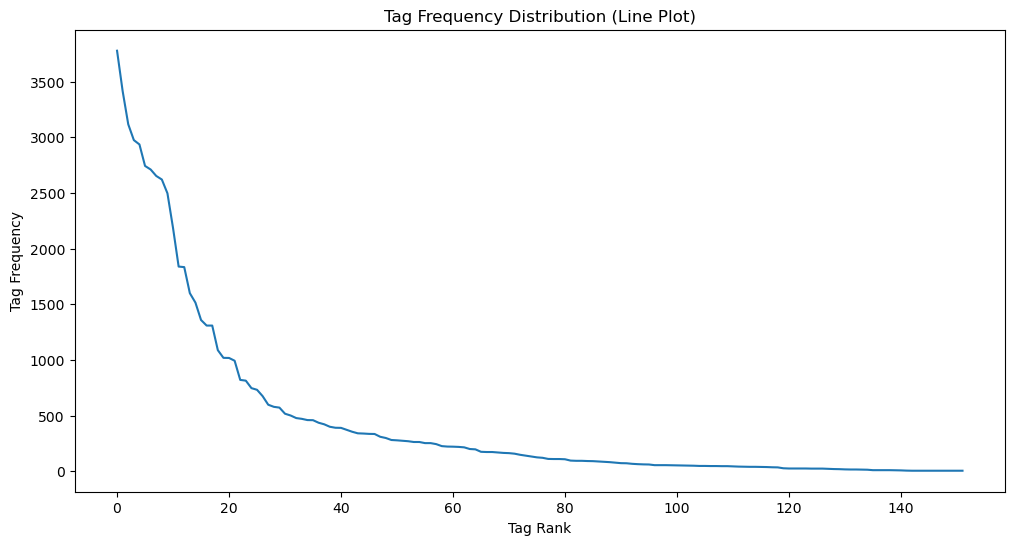

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt


#1 Convert to pandas series
all_tags = []
for tag_list in combined_df_renamed['property_tags']:
    if isinstance(tag_list, list):
        all_tags.extend(tag_list)

# Count the frequency of each tag
tag_counts = Counter(all_tags)

tag_counts_series = pd.Series(tag_counts).sort_values(ascending=False)

# Select the value from the X amount from the data.
minCount = int(tag_counts_series.values[80]) # the value of tag with the rank 15 will be taken

print("Min Count/ Threshold", minCount) # see the value to prevent making mistakes.

# Plot code for visualization
plt.figure(figsize=(12,6))
plt.plot(tag_counts_series.values)
plt.xlabel("Tag Rank")
plt.ylabel("Tag Frequency")
plt.title("Tag Frequency Distribution (Line Plot)")
plt.show()

### Dealing with Cities

1. **Train-Test Split:** The data was split into training and testing sets (80/20 split) using `train_test_split` to evaluate model performance on unseen data.

2. **Target Encoding:** Categorical features (`city`, `state`, `county`) were target encoded using the mean `sold_price` for each category within the training set.  Missing values in the test set were replaced with the overall mean `sold_price` from the training data.

3. **One-Hot Encoding (Property Tags):** The `property_tags` feature (containing lists of tags) was one-hot encoded.  Only tags appearing at least 50 times in the training set were included to reduce dimensionality and prevent overfitting on rare tags.  Missing or incorrectly formatted tag lists were handled gracefully.

In [104]:
from sklearn.model_selection import train_test_split

def preprocess_data(df):
    """
    - Splits data into train and test sets.
    - Applies target encoding to 'city', 'state', and 'county'.
    - Applies one-hot encoding to 'property_tags' (with a frequency threshold).
    - Returns cleaned train and test sets.
    """

    # Train-Test Split
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    # Target Encoding (City, State, County)
    target_cols = ['city', 'state', 'county']
    overall_mean = train_df['sold_price'].mean()

    for col in target_cols:
        mapping = train_df.groupby(col)['sold_price'].mean()
        train_df[col] = train_df[col].map(mapping)
        test_df[col] = test_df[col].map(mapping).fillna(overall_mean)

    # One-Hot Encoding for Property Tags
    if 'property_tags' in df.columns:
        # Flatten the list of all tags
        all_tags = train_df['property_tags'].explode()
        tag_counts = all_tags.value_counts()

        # Keep tags that appear at least 50 times
        frequent_tags = tag_counts[tag_counts >= 50].index.tolist()

        def encode_tags(tag_list):
            if not isinstance(tag_list, list):  # Handle None or unexpected types
                tag_list = []
            return pd.Series({tag: 1 if tag in tag_list else 0 for tag in frequent_tags})

        # Apply to train and test
        train_tags = train_df['property_tags'].apply(encode_tags)
        test_tags = test_df['property_tags'].apply(encode_tags)

        # Drop original property_tags column
        train_df = train_df.drop(columns=['property_tags']).join(train_tags)
        test_df = test_df.drop(columns=['property_tags']).join(test_tags)

    return train_df, test_df




In [105]:
# Example usage:
train_df1, test_df1 = preprocess_data(combined_df_renamed)
train_df1.shape, test_df1.shape

((5372, 124), (1344, 124))

In [106]:
display(train_df1.head())
display("====================================")
display(test_df1.head())

,list_date,year_built,baths_3qtr,sold_date,sold_price,baths_full,baths_half,lot_sqft,sqft,baths_total,...,gated_community,cathedral_ceiling,community_spa_or_hot_tub,senior_community,big_bathroom,elevator,mountain_view,rv_parking,marina,smart_homes
2793,2023-10-13 17:09:33+00:00,1930,0,2023-12-29 00:00:00+00:00,275000,1,0,3001.0,1402.0,1,...,0,0,0,0,0,0,0,0,0,0
1457,2023-10-26 20:40:21+00:00,1920,0,2024-01-12 00:00:00+00:00,825000,3,0,6600.0,3000.0,3,...,0,0,0,0,0,0,0,0,0,0
7202,2024-01-16 14:13:19+00:00,1900,0,2024-01-12 00:00:00+00:00,891000,3,0,4540.0,3601.0,3,...,0,0,0,0,0,0,0,0,0,0
7004,2023-12-13 17:26:49+00:00,1992,0,2024-01-12 00:00:00+00:00,510000,3,1,40511.0,2985.0,4,...,0,0,0,0,0,0,0,0,0,0
4506,2023-09-18 22:36:59+00:00,1920,0,2023-11-10 00:00:00+00:00,42000,2,0,4033.0,1359.0,2,...,0,0,0,0,0,0,0,0,0,0


'===================================='

,list_date,year_built,baths_3qtr,sold_date,sold_price,baths_full,baths_half,lot_sqft,sqft,baths_total,...,gated_community,cathedral_ceiling,community_spa_or_hot_tub,senior_community,big_bathroom,elevator,mountain_view,rv_parking,marina,smart_homes
7142,2023-09-29 00:00:00+00:00,2020,0,2023-08-01 00:00:00+00:00,263626,2,0,7405.0,1878.0,2,...,0,0,0,0,0,0,0,0,0,0
5083,2023-09-18 20:37:09+00:00,1951,0,2024-01-03 00:00:00+00:00,225000,1,0,10454.0,1299.0,1,...,0,0,0,0,0,0,0,0,0,0
3059,2023-12-22 23:07:58+00:00,2019,0,2024-01-09 00:00:00+00:00,710000,3,1,1307.0,2740.0,4,...,0,0,0,0,0,0,0,0,0,0
1924,2023-07-21 00:00:00+00:00,1983,0,2023-07-21 00:00:00+00:00,475000,2,0,130680.0,1633.0,2,...,0,0,0,0,0,0,0,0,0,0
4995,2023-06-16 17:28:18+00:00,1972,0,2023-12-15 00:00:00+00:00,350000,2,0,61420.0,1629.0,0,...,0,0,0,0,0,0,0,0,0,0


## Extra Data - STRETCH

> This doesn't need to be part of your Minimum Viable Product (MVP). We recommend you write a functional, basic pipeline first, then circle back and join new data if you have time

> If you do this, try to write your downstream steps in a way it will still work on a dataframe with different features!

- You're not limited to just using the data provided to you. Think/ do some research about other features that might be useful to predict housing prices. 
- Can you import and join this data? Make sure you do any necessary preprocessing and make sure it is joined correctly.
- Example suggestion: could mortgage interest rates in the year of the listing affect the price? 

In [ ]:
# import, join and preprocess new data here

## EDA/ Visualization

Remember all of the EDA that you've been learning about?  Now is a perfect time for it!
- Look at distributions of numerical variables to see the shape of the data and detect outliers.    
    - Consider transforming very skewed variables
- Scatterplots of a numerical variable and the target go a long way to show correlations.
- A heatmap will help detect highly correlated features, and we don't want these.
    - You may have too many features to do this, in which case you can simply compute the most correlated feature-pairs and list them
- Is there any overlap in any of the features? (redundant information, like number of this or that room...)

In [108]:

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import numpy as np



numerical_features = ['year_built', 'age_built', 'lot_sqft', 'sqft', 'baths_total', 'garage_spaces', 'num_stories', 'beds', 'sold_price', 'price_reduction']

# Convert numerical features to float64
for col in numerical_features:
    combined_df_renamed[col] = combined_df_renamed[col].astype('float64')



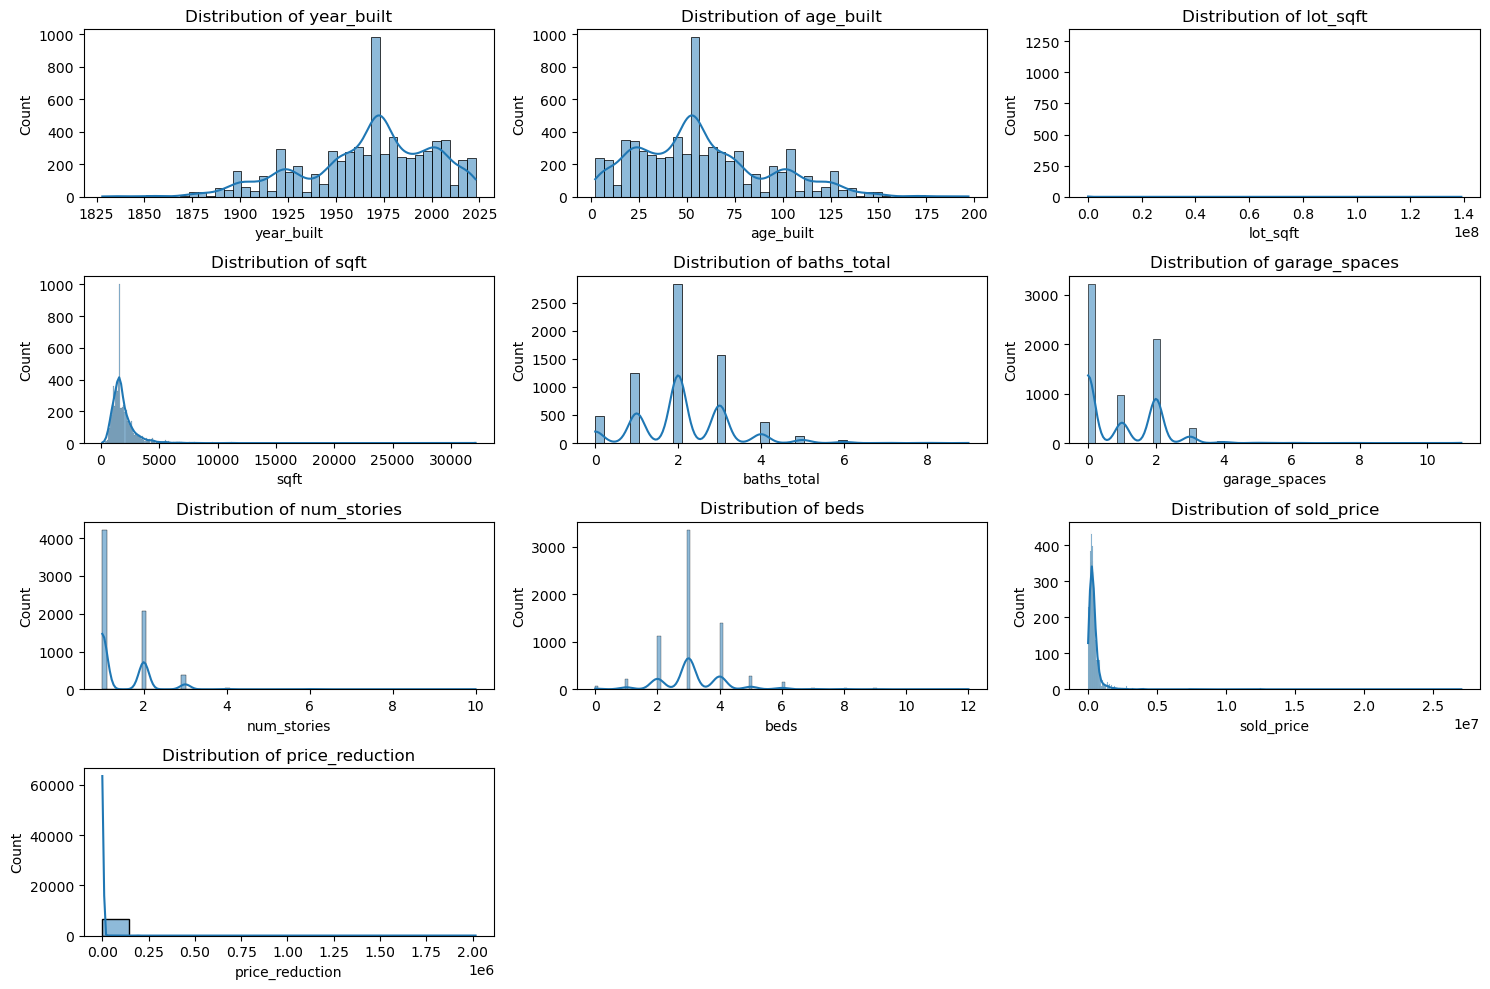

In [110]:
# 1. Distribution of Numerical Variables
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(4, 3, i + 1)  # Adjusted to 4x3 grid
    sns.histplot(combined_df_renamed[feature].dropna(), kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

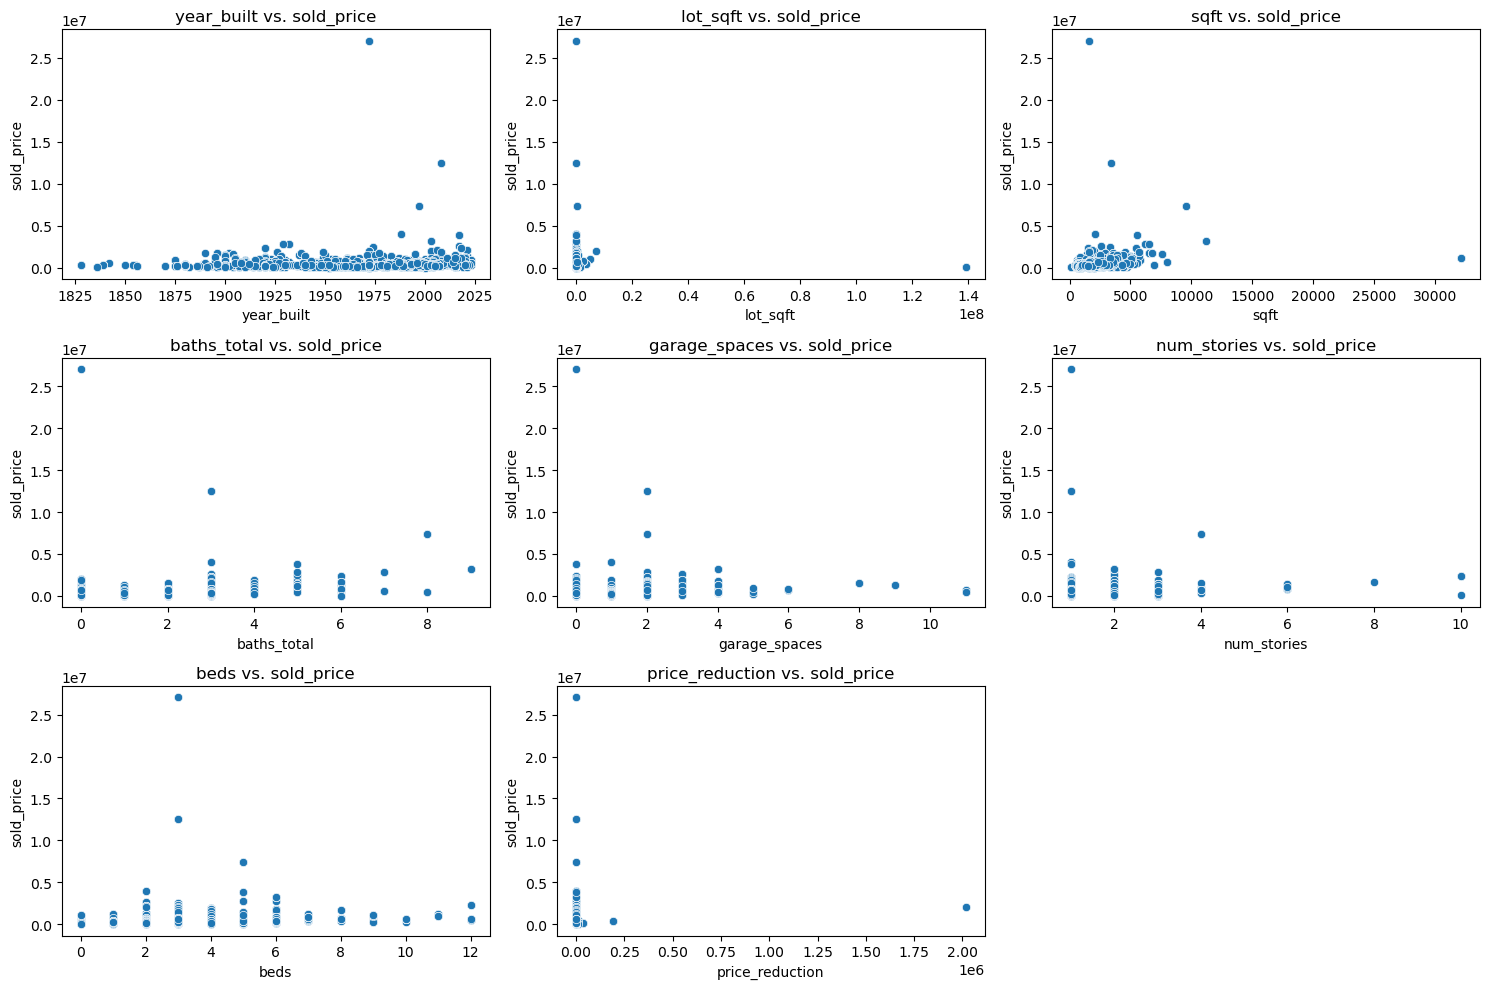

In [111]:
# 2. Scatter Plots (Numerical vs. Target)
numerical_features_for_scatter = ['year_built', 'lot_sqft', 'sqft', 'baths_total', 'garage_spaces', 'num_stories', 'beds', 'price_reduction']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features_for_scatter):
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(x=combined_df_renamed[feature].dropna(), y=combined_df_renamed['sold_price'])
    plt.title(f'{feature} vs. sold_price')
plt.tight_layout()
plt.show()

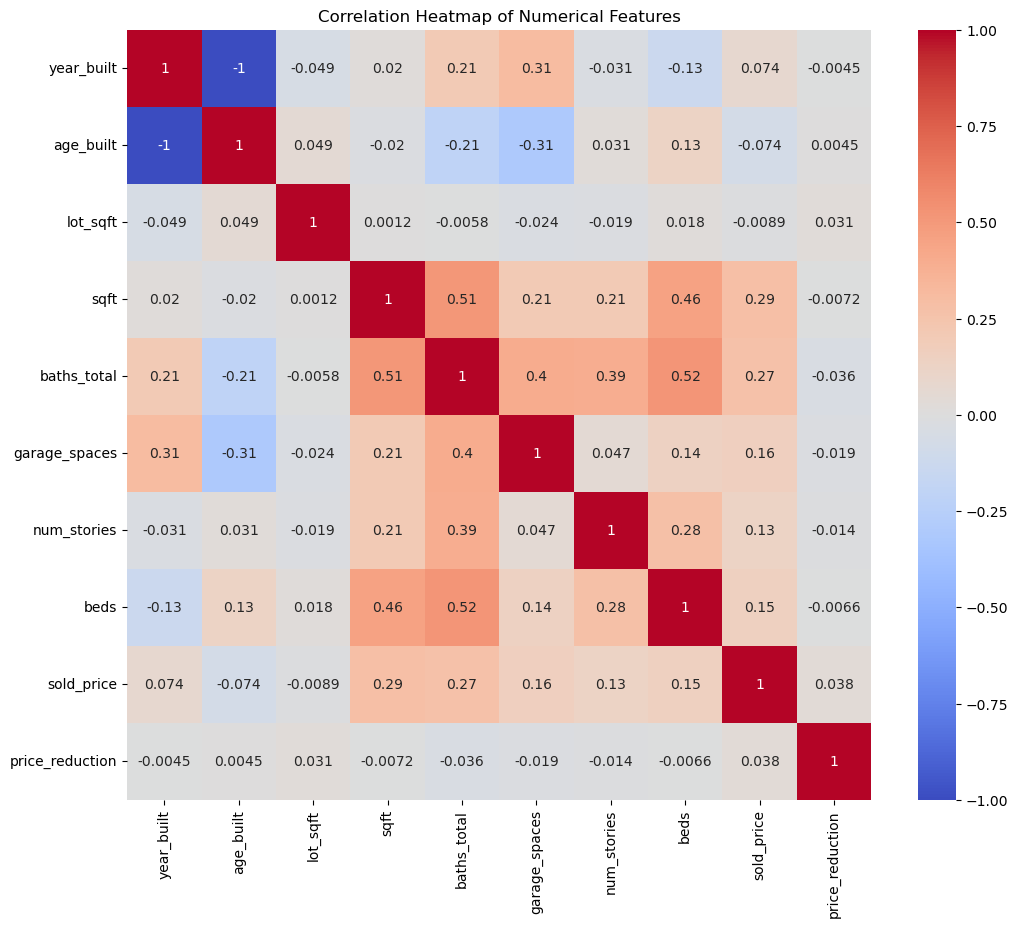

In [112]:
# 3. Heatmap or Correlation Analysis
correlation_matrix = combined_df_renamed[numerical_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [113]:
# Calculate skewness for each numerical feature individually
for col in numerical_features:
    try:
        col_skewness = skew(combined_df_renamed[col].dropna())
        print(f"Skewness for column '{col}': {col_skewness}")
    except Exception as e:
        print(f"Error calculating skewness for column '{col}': {e}")

Skewness for column 'year_built': -0.6866613062855204
Skewness for column 'age_built': 0.6866613062855196
Skewness for column 'lot_sqft': 36.464624159007705
Skewness for column 'sqft': 11.036193898629119
Skewness for column 'baths_total': 0.7213466523057027
Skewness for column 'garage_spaces': 1.8435776299707836
Skewness for column 'num_stories': 3.0633177731816783
Skewness for column 'beds': 1.9242766840631704
Skewness for column 'sold_price': 21.56843151735897
Skewness for column 'price_reduction': 56.043322816747455


In [114]:
#4. Identifying skewed features
from scipy.stats import skew

# Calculate skewness for each numerical feature in the list
skewed_feats = pd.Series({col: skew(combined_df_renamed[col].dropna()) for col in numerical_features})


skewed_feats = skewed_feats[abs(skewed_feats) > 0.5]
skewed_feats = skewed_feats.sort_values(ascending=False)
print("Skewed features: %s" % skewed_feats)

Skewed features: price_reduction    56.043323
lot_sqft           36.464624
sold_price         21.568432
sqft               11.036194
num_stories         3.063318
beds                1.924277
garage_spaces       1.843578
baths_total         0.721347
age_built           0.686661
year_built         -0.686661
dtype: float64


### Skewness Calculation Observations

### 1. Individual Skewness Calculation:
The following are the skewness values for each numerical feature in the dataset:

- **year_built**: -0.69 (moderately skewed to the left)
- **lot_sqft**: 36.46 (highly positively skewed)
- **sqft**: 11.04 (highly positively skewed)
- **baths_total**: 0.72 (moderately positively skewed)
- **garage_spaces**: 1.84 (moderately positively skewed)
- **num_stories**: 3.06 (highly positively skewed)
- **beds**: 1.92 (moderately positively skewed)
- **sold_price**: 21.57 (highly positively skewed)
- **price_reduction**: 56.04 (highly positively skewed)

### 2. Identifying Highly Skewed Features:
The following features have skewness greater than 0.5 or less than -0.5, indicating they are significantly skewed:

- **price_reduction**: 56.04 (highly positively skewed)
- **lot_sqft**: 36.46 (highly positively skewed)
- **sold_price**: 21.57 (highly positively skewed)
- **sqft**: 11.04 (highly positively skewed)
- **num_stories**: 3.06 (highly positively skewed)
- **beds**: 1.92 (moderately positively skewed)
- **garage_spaces**: 1.84 (moderately positively skewed)
- **baths_total**: 0.72 (moderately positively skewed)
- **year_built**: -0.69 (moderately skewed to the left)

### Conclusion:
- Many features are **positively skewed**, especially those related to property size (e.g., `lot_sqft`, `sqft`) and pricing (`sold_price`, `price_reduction`).
- The high skewness values in the dataset suggest that transformations (e.g., log transformation) may be needed to improve model performance, especially for regression tasks.


## Scaling and Finishing Up

Now is a great time to scale the data and save it once it's preprocessed.
- You can save it in your data folder, but you may want to make a new `processed/` subfolder to keep it organized

In [115]:
import os
from sklearn.preprocessing import StandardScaler

# Make sure the 'processed' directory exists
processed_folder = '/Users/fitsumbahlebi/Desktop/repo2/LHL-supervised-learning-midterm/data/processed'
os.makedirs(processed_folder, exist_ok=True)

# Extract numerical columns to scale (drop 'sold_price' as it's the target)
numerical_cols = train_df1.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_cols.remove('sold_price')  # We don't want to scale the target variable

# Initialize the scaler
scaler = StandardScaler()

# Scale training and testing data
train_scaled = train_df1[numerical_cols].copy()
test_scaled = test_df1[numerical_cols].copy()

# Fit and transform the training data, then transform the test data
train_scaled[numerical_cols] = scaler.fit_transform(train_scaled[numerical_cols])
test_scaled[numerical_cols] = scaler.transform(test_scaled[numerical_cols])


# Concatenate all columns at once instead of inserting individually
train_scaled = pd.concat([train_scaled, train_df1[['sold_price']]], axis=1)
test_scaled = pd.concat([test_scaled, test_df1[['sold_price']]], axis=1)

# Save the scaled data to CSV files
train_scaled.to_csv(os.path.join(processed_folder, 'train_scaled.csv'), index=False)
test_scaled.to_csv(os.path.join(processed_folder, 'test_scaled.csv'), index=False)

print("Data scaling and saving completed!")


Data scaling and saving completed!
